In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
from numpy import array
import sklearn
import graphviz
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error

import keras
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dropout, Dense, TimeDistributed, Flatten
# from keras.layers import convolutional
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
from keras import optimizers
from keras import backend as K
from keras.losses import mean_squared_error

import matplotlib.pyplot as plt
# Defaults
plt.style.use('ggplot')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 6hr resampling - 6hours data
train_df = pd.read_csv("/content/drive/MyDrive/Fog Prediction 24/Long Term Fog Prediction/6hr_dataset/6hr_re1_Jaipur_train_6h.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Fog Prediction 24/Long Term Fog Prediction/6hr_dataset/6hr_re1_Jaipur_test_6h.csv")
val_df = pd.read_csv("/content/drive/MyDrive/Fog Prediction 24/Long Term Fog Prediction/6hr_dataset/6hr_re1_Jaipur_val_6h.csv")
# 6hr resampling

# 12hr resa,pling


In [3]:
X_train = train_df[['date_time','fog_index']]
X_train.set_index("date_time", inplace = True)
X_test = test_df[['date_time','fog_index']]
X_test.set_index("date_time", inplace = True)
X_val = val_df[['date_time','fog_index']]
X_val.set_index("date_time", inplace = True)

In [4]:
print(X_train.shape, X_val.shape, X_test.shape)

(7568, 1) (1418, 1) (1898, 1)


In [5]:

scalem = MinMaxScaler(feature_range = (0, 1))

X_train_scaled = scalem.fit_transform(X_train.values.reshape(-1,1))
X_val_scaled  = scalem.fit_transform(X_val.values.reshape(-1,1))
X_test_scaled = scalem.fit_transform(X_test.values.reshape(-1,1))
X_train_scaled = X_train_scaled.tolist()

In [6]:
def insert(df, row):
    insert_loc = df.index.max()

    if pd.isna(insert_loc):
        df.loc[0] = row
    else:
        df.loc[insert_loc + 1] = row

In [7]:
def evaluation_metrics(y_test_descaled, y_predicted_descaled):
  #RMSE,MSE,MAE,R2_Score
  mse = round(sklearn.metrics.mean_squared_error(y_test_descaled, y_predicted_descaled),4)
  rmse = round(np.mean((y_predicted_descaled - y_test_descaled)**2)**.5,4)
  r2 = round(r2_score(y_test_descaled, y_predicted_descaled),4)
  mae = round(mean_absolute_error(y_test_descaled, y_predicted_descaled),4)
  # create a dataframe of y_test_descaled,y_predicted_descaled
  output = [rmse,mse,mae,r2]
  return output

In [8]:
df = pd.DataFrame(columns = ['Lead Time','Model Name','RMSE','MSE','MAE','R2 Score'])

In [9]:
def residual_plots(tmp,lead):
    tmp['error'] = tmp['y_test'] - tmp['y_pred']
    plt.figure(figsize=(10,5))
    plt.scatter(tmp['y_test'], tmp['error'])
    plt.title(lead)
    plt.xlabel('y_test')
    plt.ylabel('Residuals')
    plt.show()
    # error plots in y_test and y_pred
    plt.scatter(tmp['y_test'], tmp['y_pred'])
    plt.title(lead)
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.show()

In [10]:
def evaluation_steps(y_pred,yt,lead,name):
  #'De-normalize' the data
  # y_predicted_descaled = scalem.inverse_transform(y_pred)
  # y_train_descaled = scalem.inverse_transform(y.reshape(-1,1))
  # y_test_descaled = scalem.inverse_transform(yt.reshape(-1,1))
  # y_pred = y_pred.ravel()
  y_pred = [round(yx, 2) for yx in y_pred]
  yt = [round(yx, 2) for yx in yt]
  y_predicted_descaled = np.array(y_pred)
  y_test_descaled = np.array(yt)
  #y_tested = yt.ravel()
  tmp = pd.concat([pd.DataFrame(y_test_descaled, columns = ['y_test']), pd.DataFrame(y_predicted_descaled, columns = ['y_pred'])], axis = 1)
  print(tmp.shape)
  row = evaluation_metrics(tmp['y_test'], tmp['y_pred'])
  residual_plots(tmp,lead)
  row.insert(0, lead)
  row.insert(1, name)
  insert(df, row)

In [11]:
def pred(model, Xt, yt):
  # Xt, yt = split_sequence(X_test, n_steps_in, n_steps_out)
  Xt = Xt.reshape((Xt.shape[0], Xt.shape[1], n_features))
  # yt = yt.reshape((yt.shape[0], yt.shape[1]))
  model.evaluate(Xt, yt)
  #model.summary()
  yhat = model.predict(Xt, verbose=0)
  return Xt, yt, yhat

In [12]:
# def pred(model, X_test, n_steps=24, n_features=1):
#   Xt, yt = split_sequence(X_test, n_steps)
#   Xt = Xt.reshape((Xt.shape[0], Xt.shape[1], n_features))
#   model.evaluate(Xt, yt)
#   #model.summary()
#   yhat = model.predict(Xt, verbose=0)
#   return Xt, yt, yhat

In [13]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [14]:
# choose a number of time steps
# for 12hr step size
n_steps_in, n_steps_out = 20, 20

In [15]:
X_train, y_train = split_sequence(X_train_scaled, n_steps_in, n_steps_out)
X_val, y_val = split_sequence(X_val_scaled, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(X_test_scaled, n_steps_in, n_steps_out)

In [16]:

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [17]:
X_train.shape

(7529, 20, 1)

In [18]:
def train(model, X, y, ep, X_val, y_val, name="model"):
  model.compile(optimizer='adam',loss='mean_squared_error', metrics=[keras.metrics.RootMeanSquaredError()])
  path_checkpoint = "%s_checkpoint.h5"%name
  #EarlyStopping callback to interrupt training when the validation loss is not longer improving.
  es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=3)

  #modelckpt_callback = keras.callbacks.ModelCheckpoint( monitor="val_loss", filepath=path_checkpoint, verbose=1, save_weights_only=True, save_best_only=True)

  history = model.fit(X, y, batch_size=64, epochs=ep, verbose=1, validation_data = (X_val, y_val), callbacks=[es_callback])
  #validation_split=0.2, validation_batch_size=64,
  model.summary()
  return model, history

In [19]:
 def plot_loss(history):
  # summarize history for accuracy
  plt.plot(history.history['root_mean_squared_error'])
  plt.plot(history.history['val_root_mean_squared_error'])
  plt.title('model RMSE')
  plt.ylabel('RMSE')
  plt.xlabel('epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

In [20]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(mean_squared_error(y_true, y_pred))

# **Vanilla LSTM**

In [21]:

#Model 1 : Vanilla LSTM
model1 = Sequential()

#hidden layer - I/P shape = (samples, timesteps, features)
model1.add(LSTM(units=64, activation='relu', input_shape = (X_train.shape[1], n_features) ) )
#output layer - single numerical value
model1.add(Dense(units = 20))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 20)                1300      
                                                                 
Total params: 18196 (71.08 KB)
Trainable params: 18196 (71.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/50
118/118 [==============================] - 10s 50ms/step - loss: 0.0058 - root_mean_squared_error: 0.0764 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0575
Epoch 2/50
118/118 [==============================] - 3s 25ms/step - loss: 0.0054 - root_mean_squared_error: 0.0732 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0567
Epoch 3/50
118/118 [==============================] - 2s 16ms/step - loss: 0.0053 - root_mean_squared_error: 0.0730 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0577
Epoch 4/50
118/118 [==============================] - 2s 16ms/step - loss: 0.0053 - root_mean_squared_error: 0.0728 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0567
Epoch 5/50
118/118 [==============================] - 2s 16ms/step - loss: 0.0053 - root_mean_squared_error: 0.0727 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0565
Epoch 6/50
118/118 [==============================] - 2s 15ms/step - loss: 0.0053 - root_mean_squared_error: 0.0726 - val_loss: 0.0032

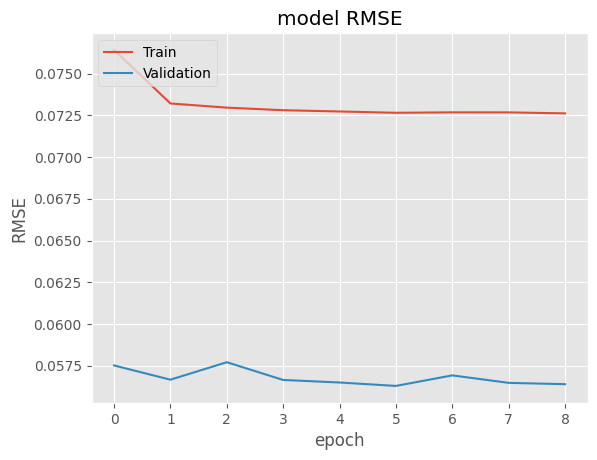

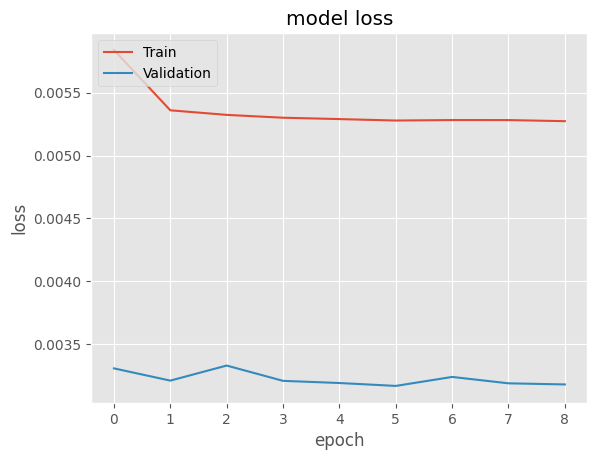

In [22]:
from tensorflow.keras.utils import plot_model
plot_model(model1, to_file='RNN.png', show_shapes=True, show_layer_names=True)
regressor1, history = train(model1, X_train, y_train, 50, X_val, y_val)
plot_loss(history)

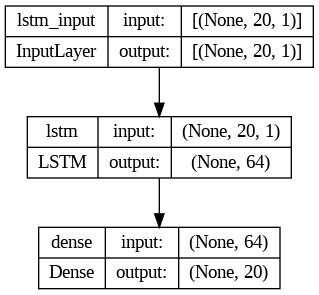

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(model1, to_file='RNN.png', show_shapes=True, show_layer_names=True)

In [24]:
Xt, yt, y_pred = pred(regressor1, X_test, y_test)

y_predicted_descaled = scalem.inverse_transform(y_pred)
y_predict = pd.DataFrame(y_predicted_descaled)

y_test_descaled = scalem.inverse_transform(yt.reshape(yt.shape[0],20))
y_test = pd.DataFrame(y_test_descaled)

59/59 [==============================] - 0s 5ms/step - loss: 0.0042 - root_mean_squared_error: 0.0648


In [25]:
y_predict.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.050349,0.052089,0.042637,0.044487,0.047835,0.049294,0.050206,0.049057,0.050334,0.055367,0.055712,0.048969,0.055774,0.055562,0.049701,0.047982,0.055351,0.059628,0.050726,0.050057


In [26]:
y_test.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.072411,0.072411,0.072411,0.0,0.072411,0.073686,0.079602,0.082146,0.084689,0.072411,0.087719,0.075352,0.072411,0.072411,0.07585,0.0,0.080957,0.073899,0.081566


(1859, 2)


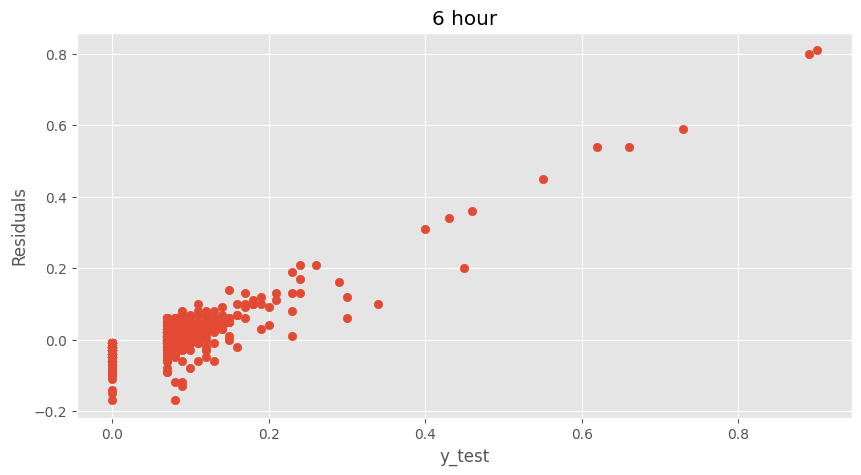

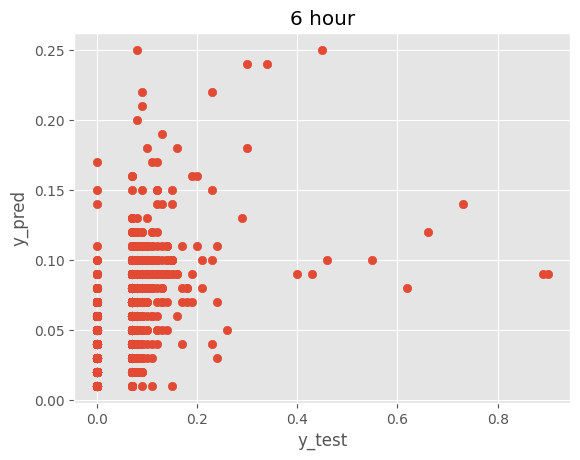

(1859, 2)


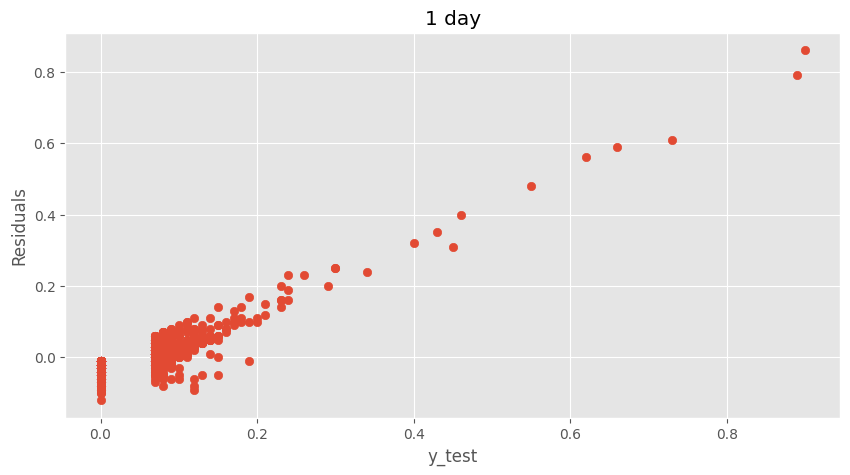

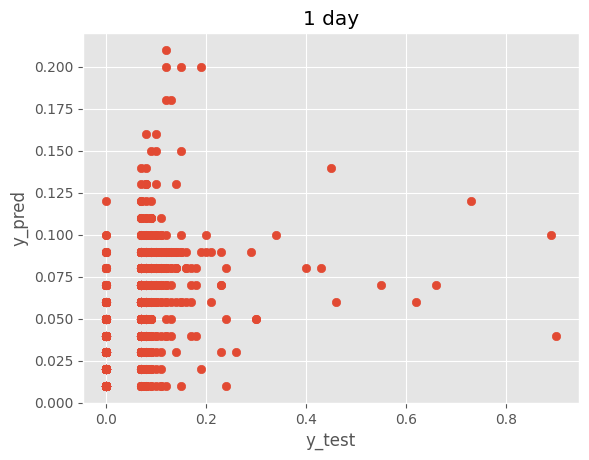

(1859, 2)


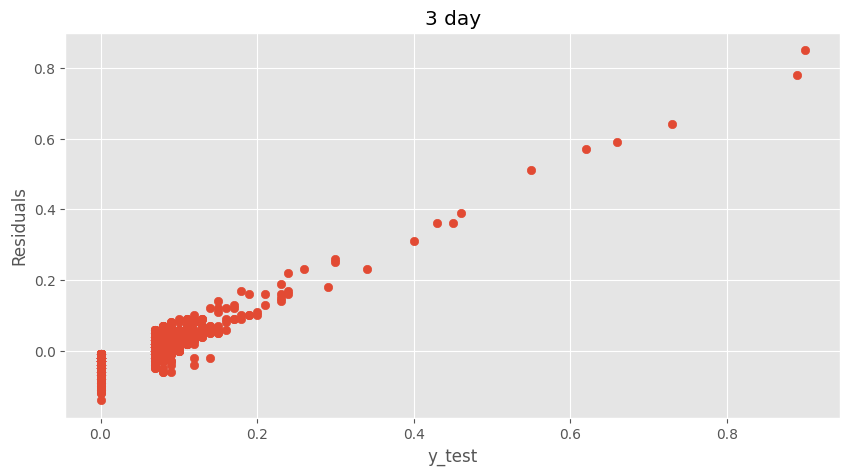

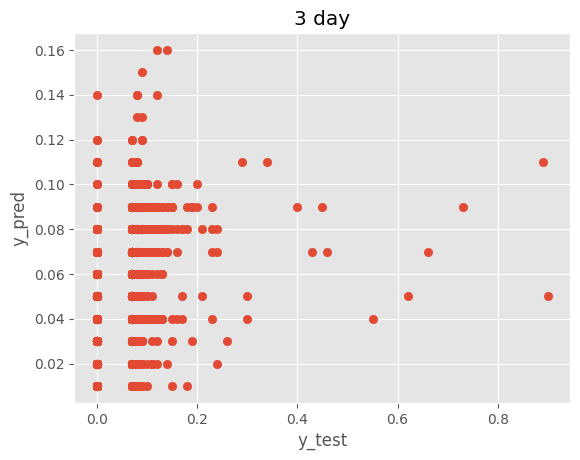

(1859, 2)


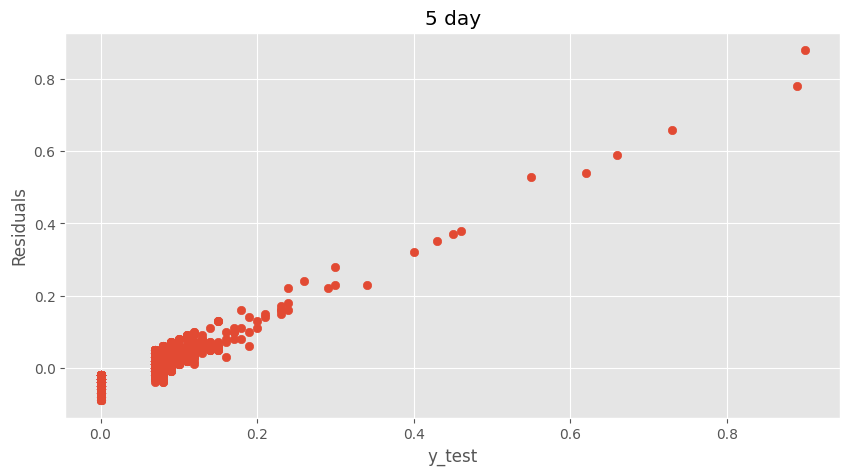

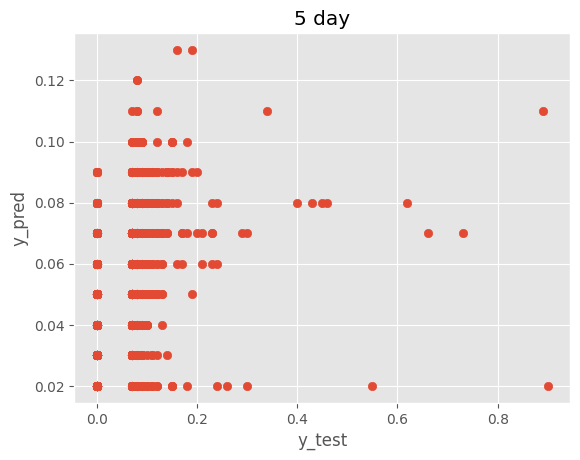

In [27]:
# 6hr(1) , 1 day(4), 3 day(12), 5 day(20)
# for 6hr resampling
count = [0,3,11,19]
model_name = ['6 hour','1 day','3 day','5 day']
# # for 3hr resampling
# count = [1,7,23,39]
# model_name = ['6 hour','1 day','3 day','5 day']
# For 12hr resampling
# count = [1,5,9]
# model_name = ['1 day','3 day','5 day']
i = 0
for f, b in zip(model_name, count):
    evaluation_steps(y_predict[b],y_test[b],f,'Vanialla LSTM')
    i+=1

In [28]:
df

,Lead Time,Model Name,RMSE,MSE,MAE,R2 Score
0,6 hour,Vanialla LSTM,0.0540,0.0029,0.0310,0.2504
1,1 day,Vanialla LSTM,0.0568,0.0032,0.0324,0.1704
2,3 day,Vanialla LSTM,0.0588,0.0035,0.0344,0.1134
3,5 day,Vanialla LSTM,0.0590,0.0035,0.0349,0.1102


# **Stacked LSTM**

In [29]:

#Model 2 : Stacked LSTM
model2 = Sequential()
#make lstm layer output a value at each time step so that next hidden layer gets 3D input
model2.add(LSTM(units=64, activation='relu', return_sequences=True, input_shape = (X_train.shape[1], n_features)))
model2.add(LSTM(16, activation='relu'))
model2.add(Dense(units=20))
model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20, 64)            16896     
                                                                 
 lstm_2 (LSTM)               (None, 16)                5184      
                                                                 
 dense_1 (Dense)             (None, 20)                340       
                                                                 
Total params: 22420 (87.58 KB)
Trainable params: 22420 (87.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
118/118 [==============================] - 7s 34ms/step - loss: 0.0063 - root_mean_squared_error: 0.0796 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0578
Epoch 2/100
118/118 [==============================] - 4s 35ms/step - loss: 0.0055 - root_mean_squared_error: 0.0741 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0573
Epoch 3/100
118/118 [==============================] - 3s 25ms/step - loss: 0.0054 - root_mean_squared_error: 0.0733 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0570
Epoch 4/100
118/118 [==============================] - 3s 25ms/step - loss: 0.0053 - root_mean_squared_error: 0.0731 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0569
Epoch 5/100
118/118 [==============================] - 3s 26ms/step - loss: 0.0053 - root_mean_squared_error: 0.0730 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0570
Epoch 6/100
118/118 [==============================] - 5s 39ms/step - loss: 0.0053 - root_mean_squared_error: 0.0729 - val_loss: 0

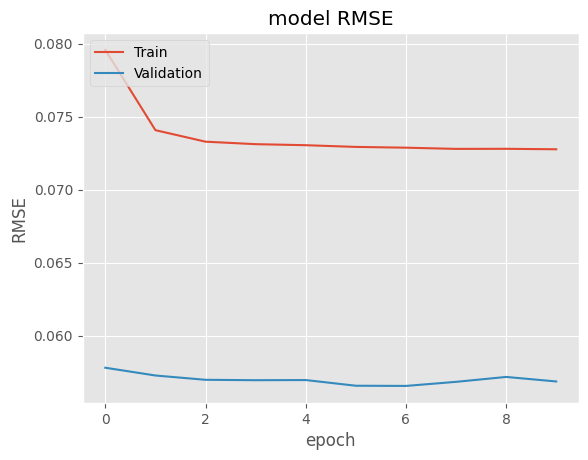

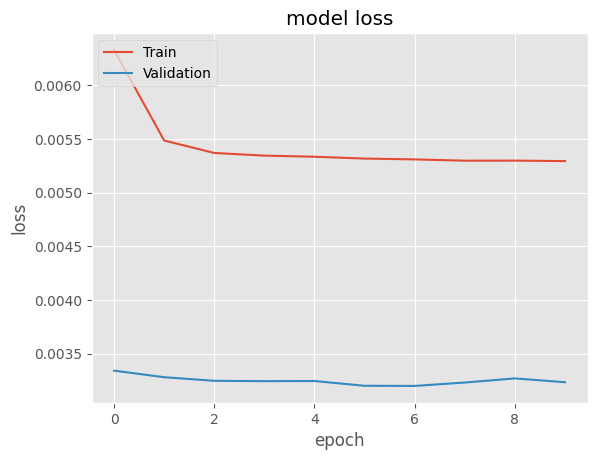

In [30]:
from tensorflow.keras.utils import plot_model
plot_model(model2, to_file='RNN.png', show_shapes=True, show_layer_names=True)
regressor2, history = train(model2, X_train, y_train, 100, X_val, y_val)
plot_loss(history)

In [31]:
def pred1(model, Xt, yt):
  n_features = 1 # Assuming n_features is 1 based on the provided context
  Xt = Xt.reshape((Xt.shape[0], Xt.shape[1], n_features))
  # Ensure yt has a defined shape with a known rank
  yt = yt.reshape((yt.shape[0], yt.shape[1], 1))  # Add an extra dimension for consistency
  model.evaluate(Xt, yt)
  yhat = model.predict(Xt, verbose=0)
  return Xt, yt, yhat

In [32]:
print(X_test.shape)
print(y_test.shape)
Xt, yt, y_pred = pred1(regressor2, X_test, y_test.values)

y_predicted_descaled = scalem.inverse_transform(y_pred)
y_predict = pd.DataFrame(y_predicted_descaled)

y_test_descaled = scalem.inverse_transform(yt.reshape(yt.shape[0],20))
y_test = pd.DataFrame(y_test_descaled)

(1859, 20, 1)
(1859, 20)
59/59 [==============================] - 1s 10ms/step - loss: 0.0035 - root_mean_squared_error: 0.0594


(1859, 2)


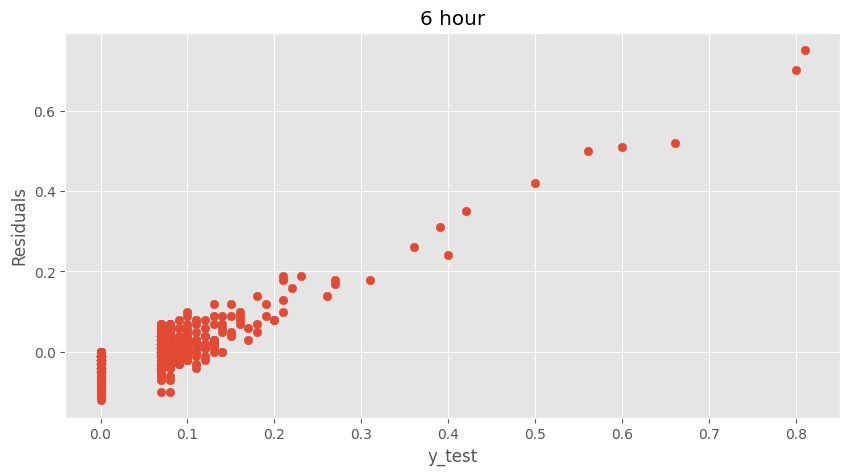

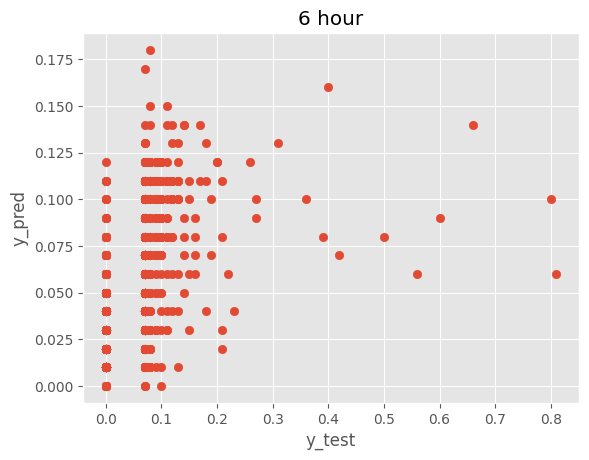

(1859, 2)


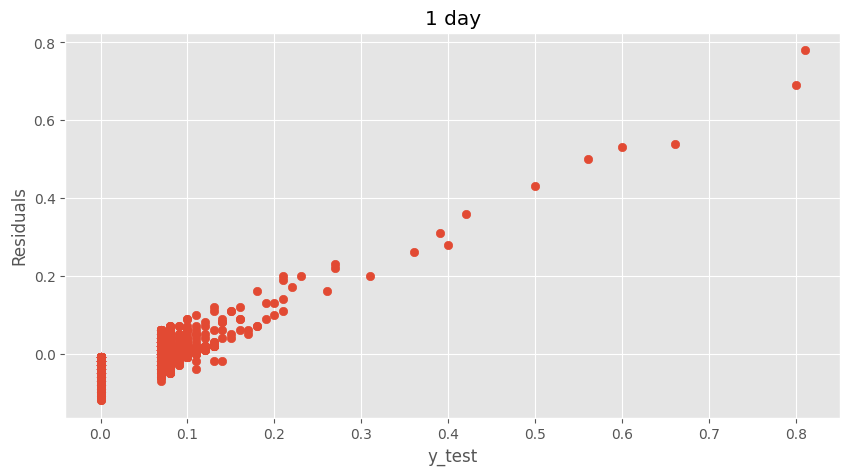

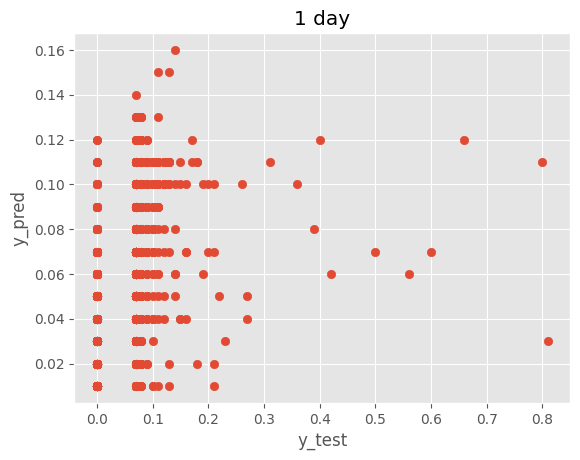

(1859, 2)


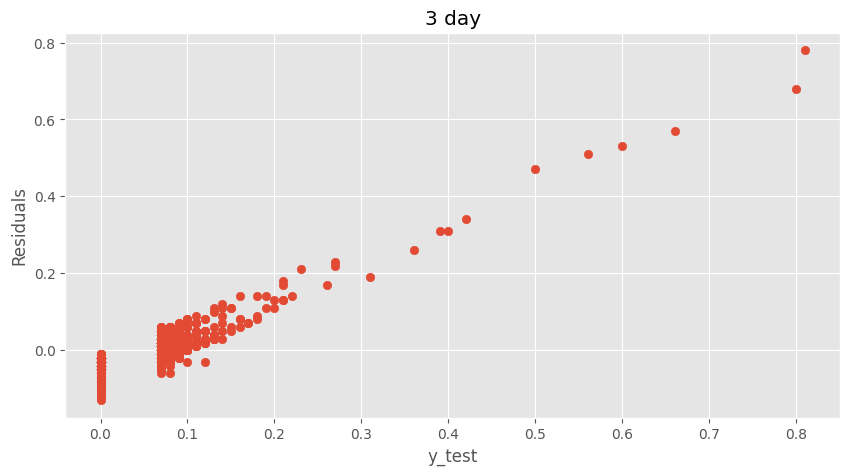

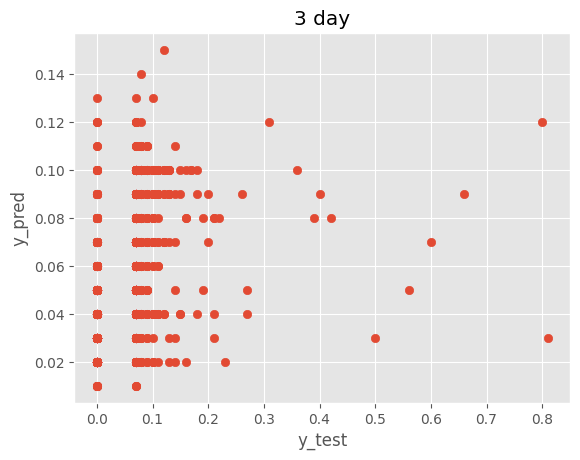

(1859, 2)


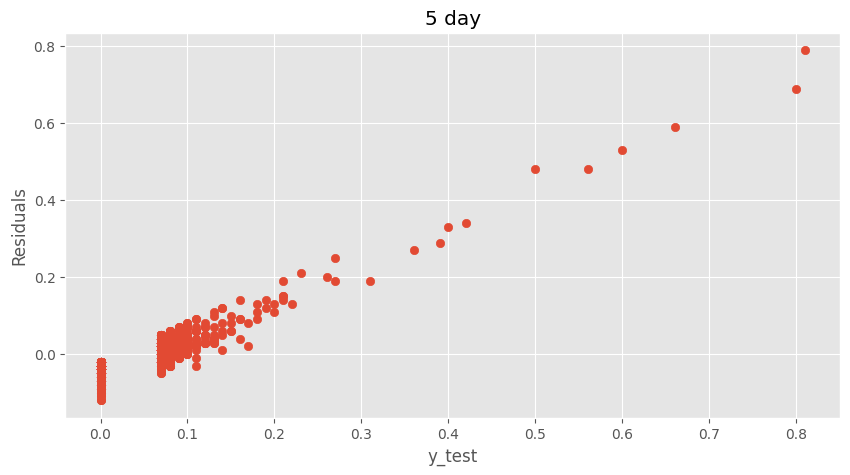

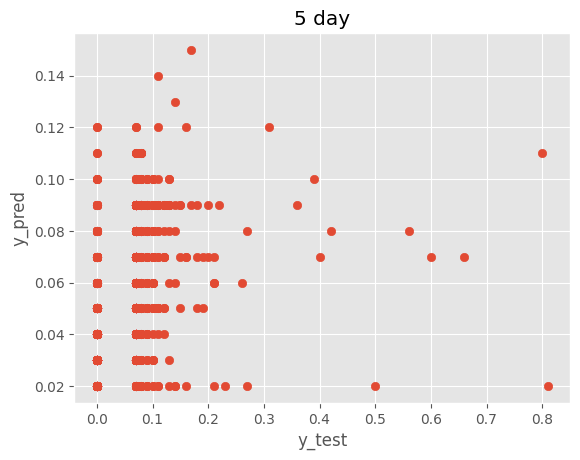

In [33]:
# 6hr(1) , 1 day(4), 3 day(12), 5 day(20)
# for 6hr resampling
count = [0,3,11,19]
model_name = ['6 hour','1 day','3 day','5 day']
# # for 3hr resampling
# count = [1,7,23,39]
# model_name = ['6 hour','1 day','3 day','5 day']
# For 12hr resampling
# count = [1,5,9]
# model_name = ['1 day','3 day','5 day']
i = 0
for f, b in zip(model_name, count):
    evaluation_steps(y_predict[b],y_test[b],f,'Stacked LSTM')
    i+=1

In [34]:
df

,Lead Time,Model Name,RMSE,MSE,MAE,R2 Score
0,6 hour,Vanialla LSTM,0.0540,0.0029,0.0310,0.2504
1,1 day,Vanialla LSTM,0.0568,0.0032,0.0324,0.1704
2,3 day,Vanialla LSTM,0.0588,0.0035,0.0344,0.1134
3,5 day,Vanialla LSTM,0.0590,0.0035,0.0349,0.1102
4,6 hour,Stacked LSTM,0.0511,0.0026,0.0307,0.1917
5,1 day,Stacked LSTM,0.0532,0.0028,0.0322,0.1247
6,3 day,Stacked LSTM,0.0543,0.0029,0.0335,0.0901
7,5 day,Stacked LSTM,0.0543,0.0030,0.0335,0.0906


# **Stacked LSTM with Dropout**

In [35]:

#Model 3 : Stacked LSTM with Dropout
model3 = Sequential()

model3.add(LSTM(128, activation="relu", return_sequences=True, input_shape = (X_train.shape[1], n_features)))
model3.add(Dropout(0.1))
model3.add(LSTM(64, activation="relu", return_sequences=True))
model3.add(Dropout(0.1))
#model3.add(LSTM(64, activation="relu", return_sequences=True))
model3.add(LSTM(16, activation="relu"))
model3.add(Dense(20))


In [36]:
def pred3(model, Xt, yt):
  Xt = Xt.reshape((Xt.shape[0], Xt.shape[1], n_features))
  # Convert yt to a NumPy array before reshaping
  yt = yt.values.reshape((yt.shape[0], yt.shape[1], 1))  # Add an extra dimension for consistency
  model.evaluate(Xt, yt)
  yhat = model.predict(Xt, verbose=0)
  return Xt, yt, yhat

Epoch 1/100
118/118 [==============================] - 16s 105ms/step - loss: 0.0061 - root_mean_squared_error: 0.0781 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0576
Epoch 2/100
118/118 [==============================] - 12s 103ms/step - loss: 0.0055 - root_mean_squared_error: 0.0740 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0578
Epoch 3/100
118/118 [==============================] - 9s 79ms/step - loss: 0.0054 - root_mean_squared_error: 0.0734 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0572
Epoch 4/100
118/118 [==============================] - 12s 100ms/step - loss: 0.0054 - root_mean_squared_error: 0.0733 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0568
Epoch 5/100
118/118 [==============================] - 12s 100ms/step - loss: 0.0054 - root_mean_squared_error: 0.0732 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0576
Epoch 6/100
118/118 [==============================] - 10s 84ms/step - loss: 0.0053 - root_mean_squared_error: 0.0730 - va

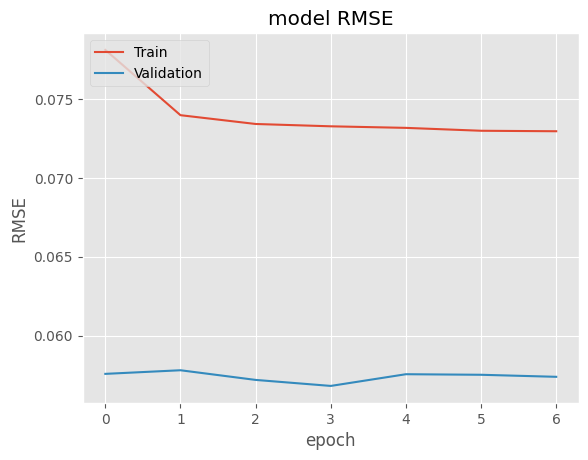

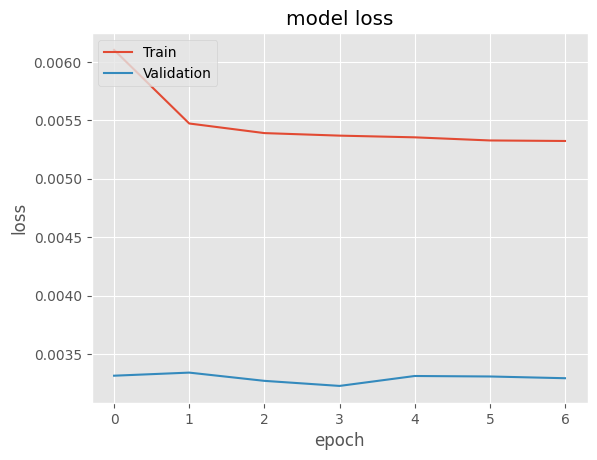

In [37]:
from tensorflow.keras.utils import plot_model
plot_model(model1, to_file='RNN.png', show_shapes=True, show_layer_names=True)
regressor3, history = train(model3, X_train, y_train, 100, X_val, y_val)
plot_loss(history)

In [38]:
Xt, yt, y_pred = pred1(regressor2, X_test, y_test.values)

y_predicted_descaled = scalem.inverse_transform(y_pred)
y_predict = pd.DataFrame(y_predicted_descaled)

y_test_descaled = scalem.inverse_transform(yt.reshape(yt.shape[0],20))
y_test = pd.DataFrame(y_test_descaled)

59/59 [==============================] - 1s 8ms/step - loss: 0.0030 - root_mean_squared_error: 0.0550


(1859, 2)


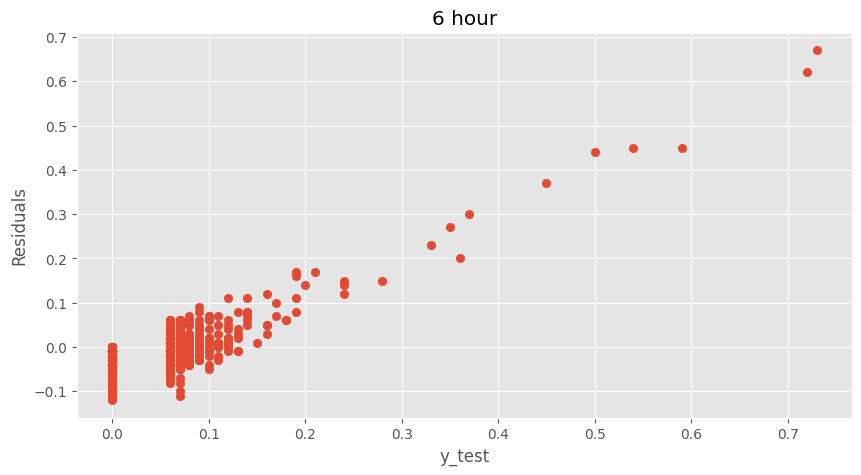

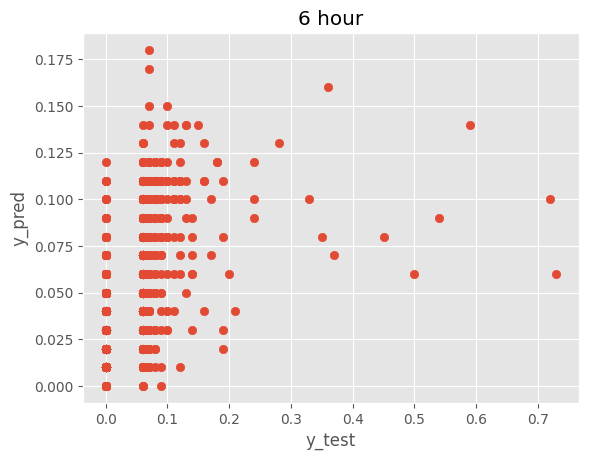

(1859, 2)


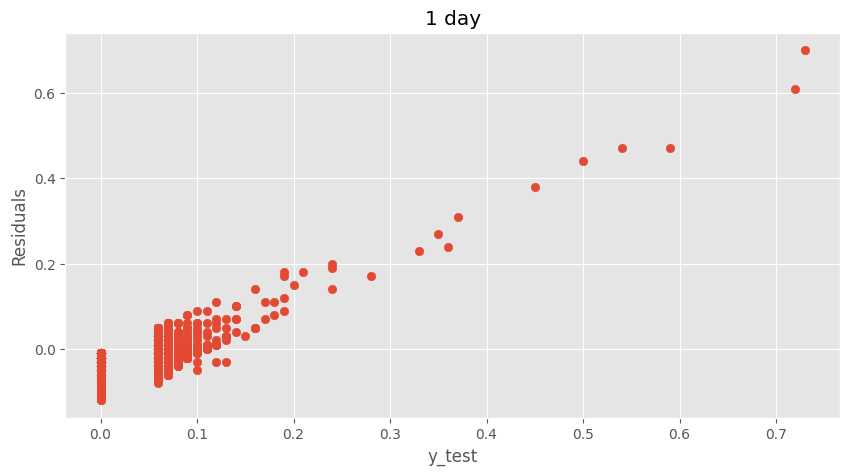

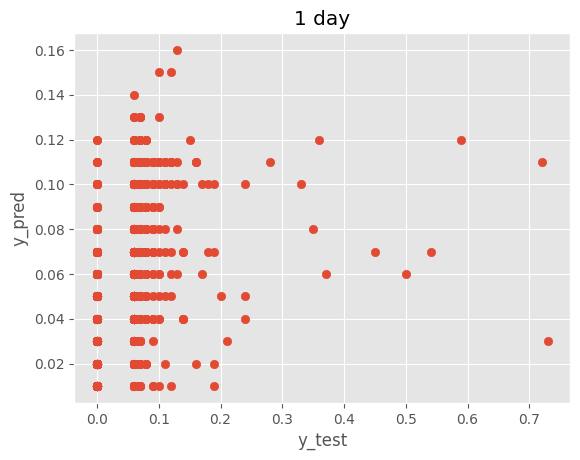

(1859, 2)


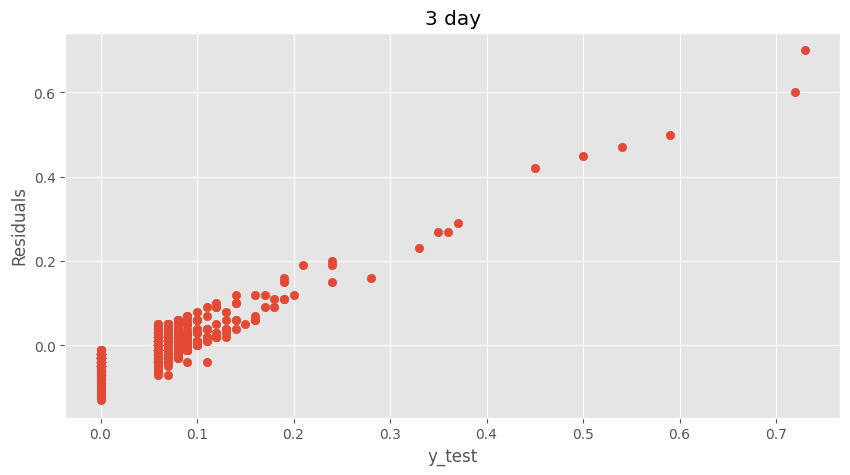

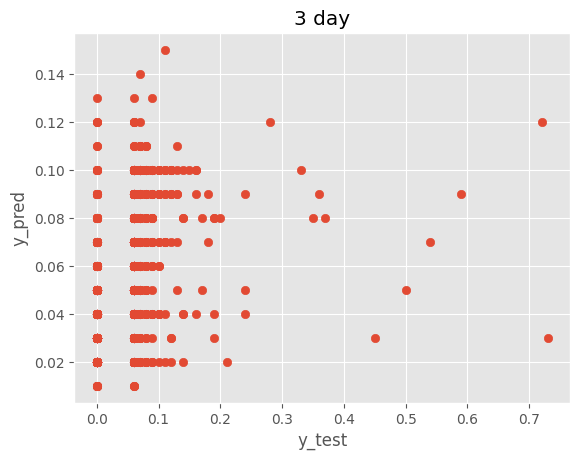

(1859, 2)


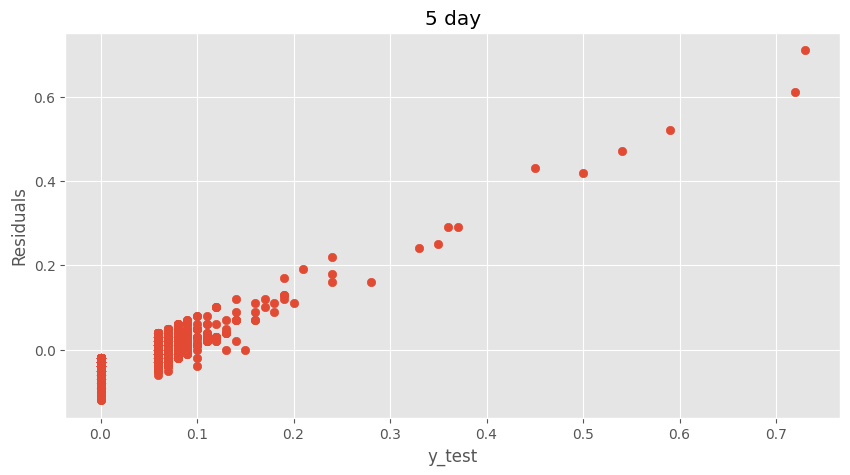

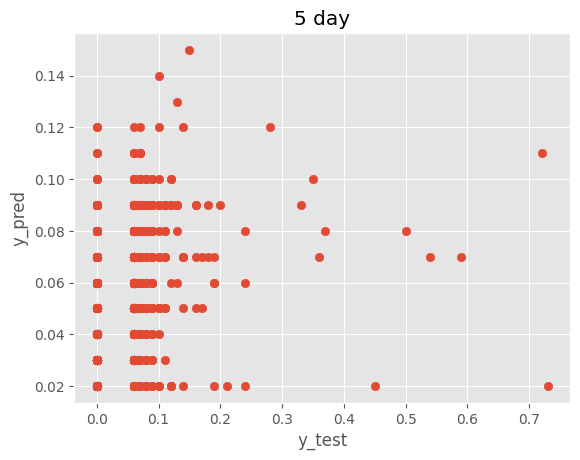

In [39]:
# 6hr(1) , 1 day(4), 3 day(12), 5 day(20)
# for 6hr resampling
count = [0,3,11,19]
model_name = ['6 hour','1 day','3 day','5 day']
# # for 3hr resampling
# count = [1,7,23,39]
# model_name = ['6 hour','1 day','3 day','5 day']
# For 12hr resampling
# count = [1,5,9]
# model_name = ['1 day','3 day','5 day']
i = 0
for f, b in zip(model_name, count):
    evaluation_steps(y_predict[b],y_test[b],f,'Stacked LSTM with Dropout LSTM')
    i+=1

In [40]:
df

,Lead Time,Model Name,RMSE,MSE,MAE,R2 Score
0,6 hour,Vanialla LSTM,0.0540,0.0029,0.0310,0.2504
1,1 day,Vanialla LSTM,0.0568,0.0032,0.0324,0.1704
2,3 day,Vanialla LSTM,0.0588,0.0035,0.0344,0.1134
3,5 day,Vanialla LSTM,0.0590,0.0035,0.0349,0.1102
4,6 hour,Stacked LSTM,0.0511,0.0026,0.0307,0.1917
5,1 day,Stacked LSTM,0.0532,0.0028,0.0322,0.1247
6,3 day,Stacked LSTM,0.0543,0.0029,0.0335,0.0901
7,5 day,Stacked LSTM,0.0543,0.0030,0.0335,0.0906
8,6 hour,Stacked LSTM with Dropout LSTM,0.0471,0.0022,0.0297,0.1391
9,1 day,Stacked LSTM with Dropout LSTM,0.0492,0.0024,0.0311,0.0611


# **Bidirectional LSTM**

In [41]:
#Model 4 : Bidirectional LSTM
model4 = Sequential()
#wrapper bidirectional layer to learn the input sequence both forward and backwards and concatenate both interpretations.
model4.add(Bidirectional((LSTM(64, activation='relu', input_shape = (X_train.shape[1], n_features)))))
model4.add(Dense(units=20))

Epoch 1/100
118/118 [==============================] - 6s 28ms/step - loss: 0.0058 - root_mean_squared_error: 0.0759 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0571
Epoch 2/100
118/118 [==============================] - 3s 25ms/step - loss: 0.0053 - root_mean_squared_error: 0.0731 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0566
Epoch 3/100
118/118 [==============================] - 4s 33ms/step - loss: 0.0053 - root_mean_squared_error: 0.0728 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0565
Epoch 4/100
118/118 [==============================] - 4s 33ms/step - loss: 0.0053 - root_mean_squared_error: 0.0726 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0567
Epoch 5/100
118/118 [==============================] - 3s 25ms/step - loss: 0.0053 - root_mean_squared_error: 0.0726 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0566
Epoch 6/100
118/118 [==============================] - 3s 25ms/step - loss: 0.0053 - root_mean_squared_error: 0.0725 - val_loss: 0

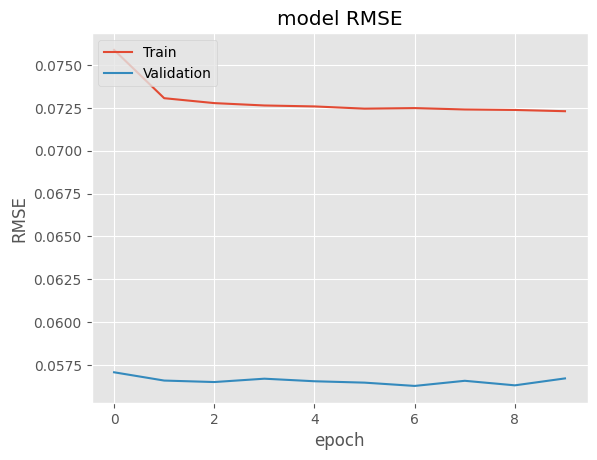

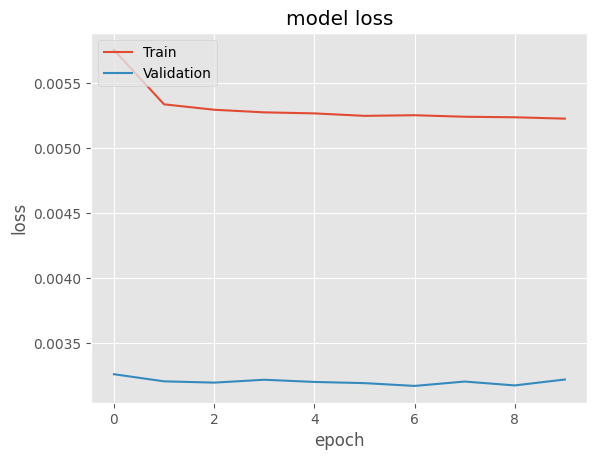

In [42]:
from tensorflow.keras.utils import plot_model
#plot_model(model4, to_file='RNN.png', show_shapes=True, show_layer_names=True)
regressor4, history = train(model4, X_train, y_train, 100, X_val, y_val)
plot_loss(history)

In [43]:
Xt, yt, y_pred = pred1(regressor4, X_test, y_test.values)

y_predicted_descaled = scalem.inverse_transform(y_pred)
y_predict = pd.DataFrame(y_predicted_descaled)

y_test_descaled = scalem.inverse_transform(yt.reshape(yt.shape[0],20))
y_test = pd.DataFrame(y_test_descaled)

59/59 [==============================] - 0s 7ms/step - loss: 0.0028 - root_mean_squared_error: 0.0527


(1859, 2)


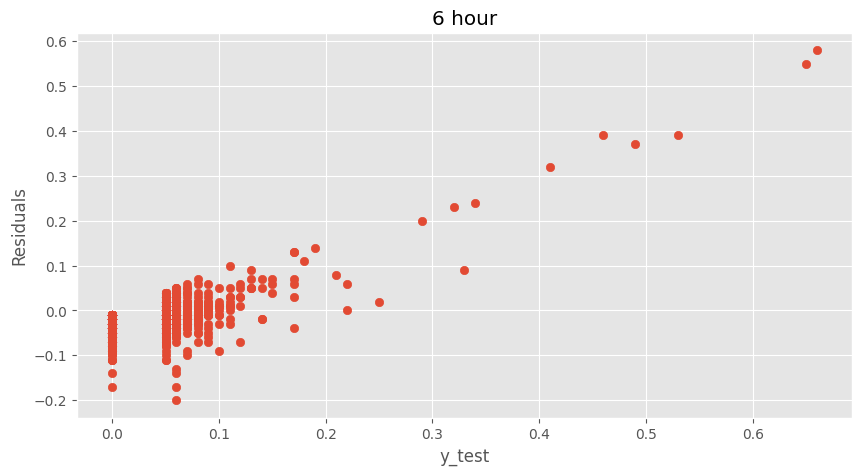

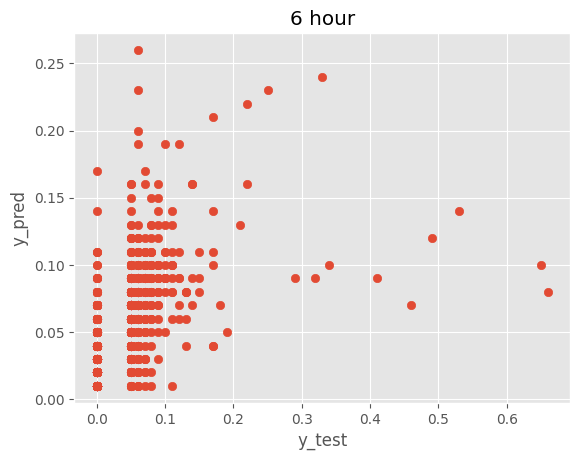

(1859, 2)


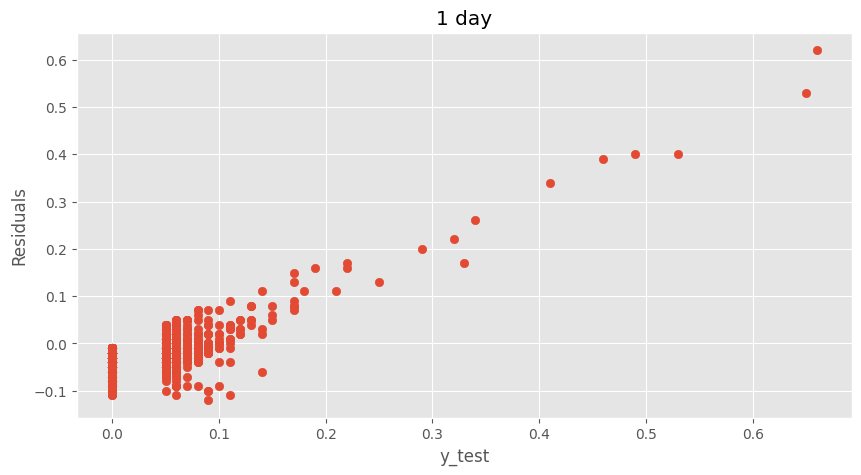

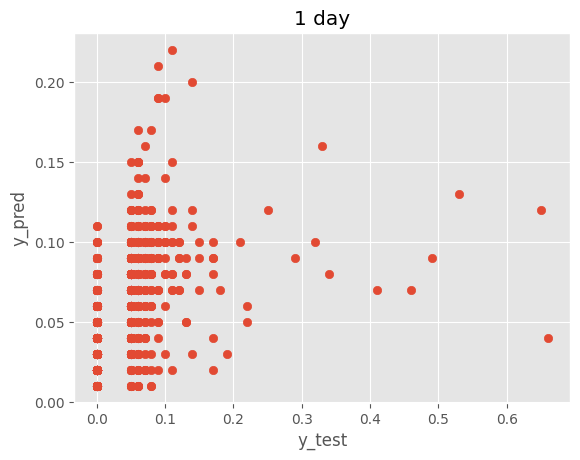

(1859, 2)


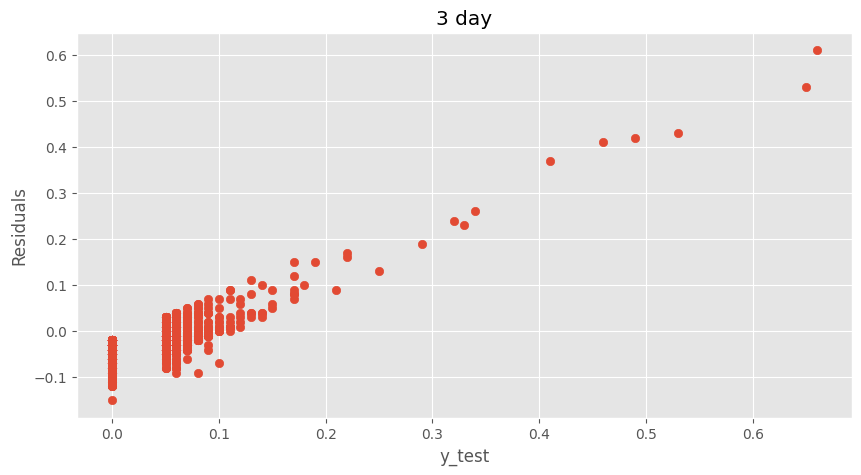

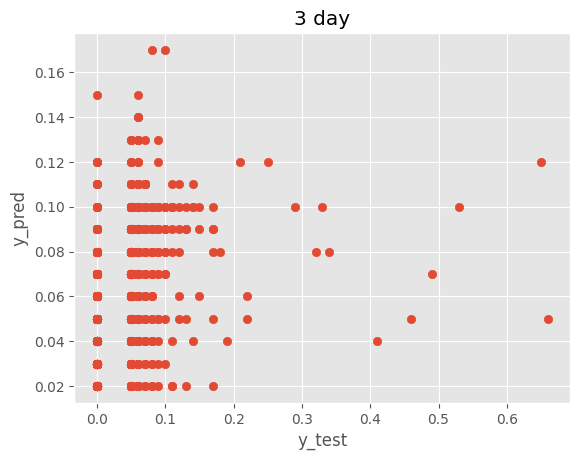

(1859, 2)


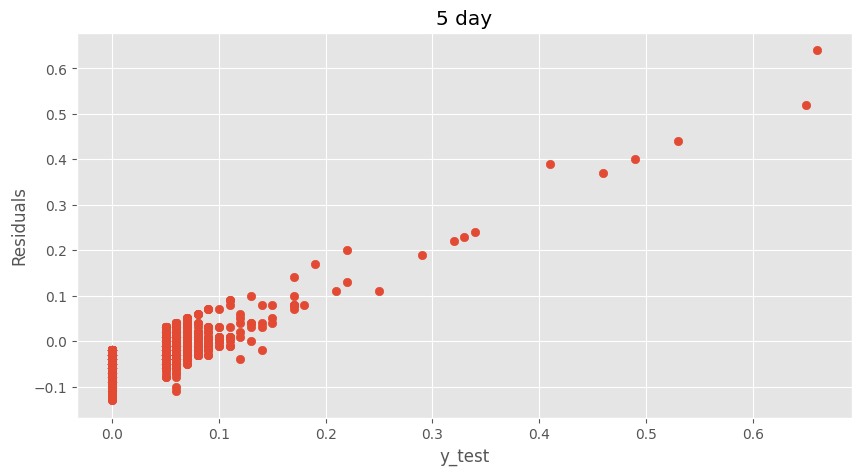

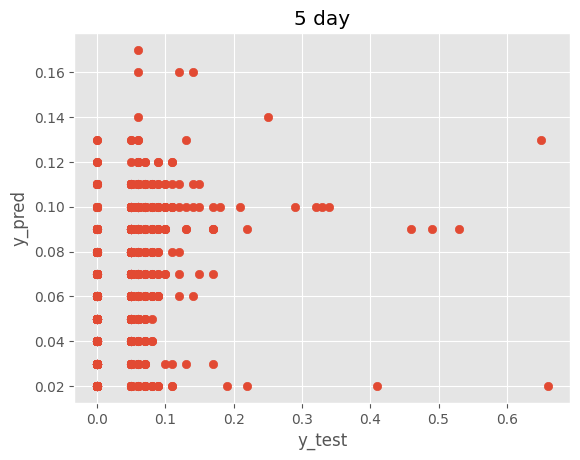

In [44]:
# 6hr(1) , 1 day(4), 3 day(12), 5 day(20)
# for 6hr resampling
count = [0,3,11,19]
model_name = ['6 hour','1 day','3 day','5 day']
# # for 3hr resampling
# count = [1,7,23,39]
# model_name = ['6 hour','1 day','3 day','5 day']
# For 12hr resampling
# count = [1,5,9]
# model_name = ['1 day','3 day','5 day']
i = 0
for f, b in zip(model_name, count):
    evaluation_steps(y_predict[b],y_test[b],f,'Bidirectional LSTM')
    i+=1

In [45]:
df

,Lead Time,Model Name,RMSE,MSE,MAE,R2 Score
0,6 hour,Vanialla LSTM,0.0540,0.0029,0.0310,0.2504
1,1 day,Vanialla LSTM,0.0568,0.0032,0.0324,0.1704
2,3 day,Vanialla LSTM,0.0588,0.0035,0.0344,0.1134
3,5 day,Vanialla LSTM,0.0590,0.0035,0.0349,0.1102
4,6 hour,Stacked LSTM,0.0511,0.0026,0.0307,0.1917
5,1 day,Stacked LSTM,0.0532,0.0028,0.0322,0.1247
6,3 day,Stacked LSTM,0.0543,0.0029,0.0335,0.0901
7,5 day,Stacked LSTM,0.0543,0.0030,0.0335,0.0906
8,6 hour,Stacked LSTM with Dropout LSTM,0.0471,0.0022,0.0297,0.1391
9,1 day,Stacked LSTM with Dropout LSTM,0.0492,0.0024,0.0311,0.0611


In [46]:
#Model 4 : Bidirectional LSTM
model5 = Sequential()
# First LSTM layer
model5.add(Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.1), input_shape=(X_train.shape[1], n_features)))
# model5.add(Dropout(0.1))

# Second LSTM layer
model5.add(Bidirectional(LSTM(units=16, return_sequences=True)))
# model5.add(Dropout(0.2))

# # Third LSTM layer
model5.add(Bidirectional(LSTM(units=8, return_sequences=True)))
# model5.add(Dropout(0.2))

# # Forth LSTM layer
# model5.add(Bidirectional(LSTM(units=50, return_sequences=False)))
# model5.add(Dropout(0.5))

# #First Dense Layer
# model5.add(Dense(units=128,kernel_initializer='he_normal',activation='relu'))
# model5.add(Dropout(0.2))
model5.add(Dense(units=20))

In [47]:
y_val.shape

(1379, 20, 1)

In [48]:
y_train.shape

(7529, 20, 1)

In [49]:
X_val.shape

(1379, 20, 1)

In [50]:
X_train.shape

(7529, 20, 1)

In [51]:
regressor5, history = train(model5, X_train, y_train, 100, X_val, y_val)

Epoch 1/100
118/118 [==============================] - 29s 118ms/step - loss: 0.0058 - root_mean_squared_error: 0.0764 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0571
Epoch 2/100
118/118 [==============================] - 12s 98ms/step - loss: 0.0054 - root_mean_squared_error: 0.0734 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0569
Epoch 3/100
118/118 [==============================] - 13s 108ms/step - loss: 0.0054 - root_mean_squared_error: 0.0732 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0570
Epoch 4/100
118/118 [==============================] - 13s 109ms/step - loss: 0.0054 - root_mean_squared_error: 0.0732 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0569
Epoch 5/100
118/118 [==============================] - 13s 107ms/step - loss: 0.0054 - root_mean_squared_error: 0.0732 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0572
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Outp

In [52]:
Xt, yt, y_pred = pred1(regressor4, X_test, y_test.values)

y_predicted_descaled = scalem.inverse_transform(y_pred)
y_predict = pd.DataFrame(y_predicted_descaled)

y_test_descaled = scalem.inverse_transform(yt.reshape(yt.shape[0],20))
y_test = pd.DataFrame(y_test_descaled)

59/59 [==============================] - 0s 7ms/step - loss: 0.0026 - root_mean_squared_error: 0.0510


(1859, 2)


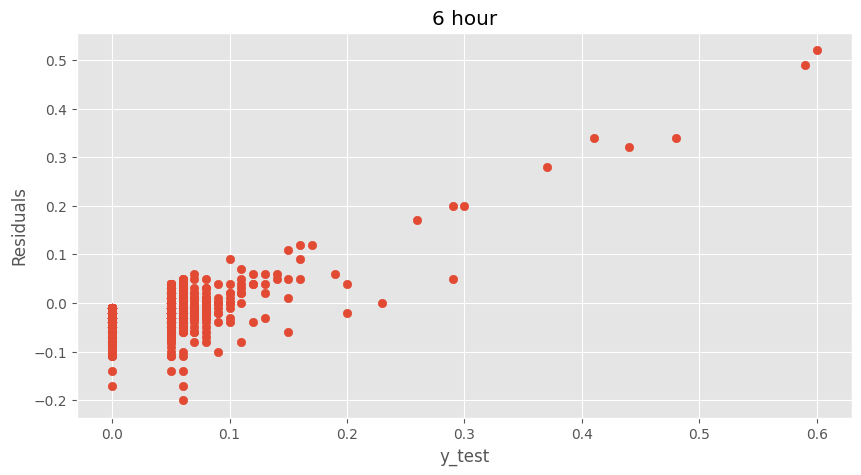

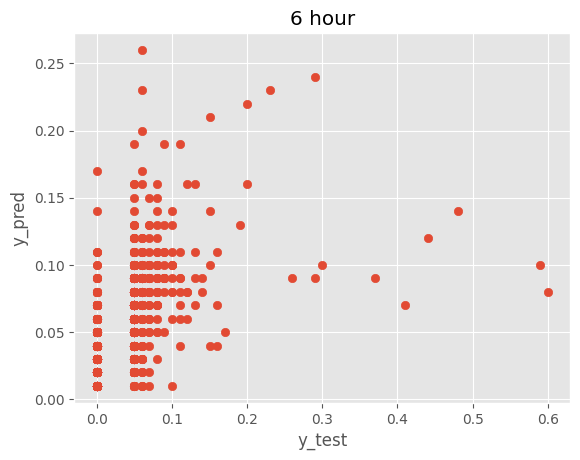

(1859, 2)


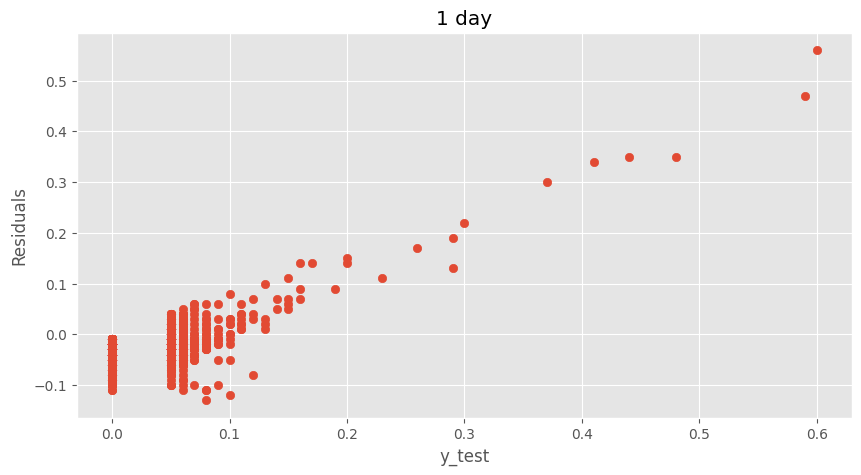

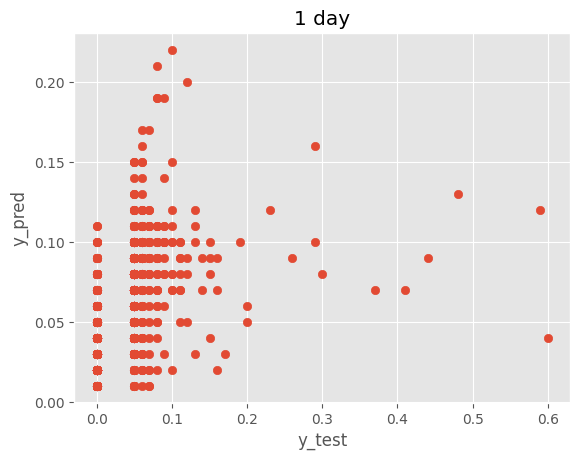

(1859, 2)


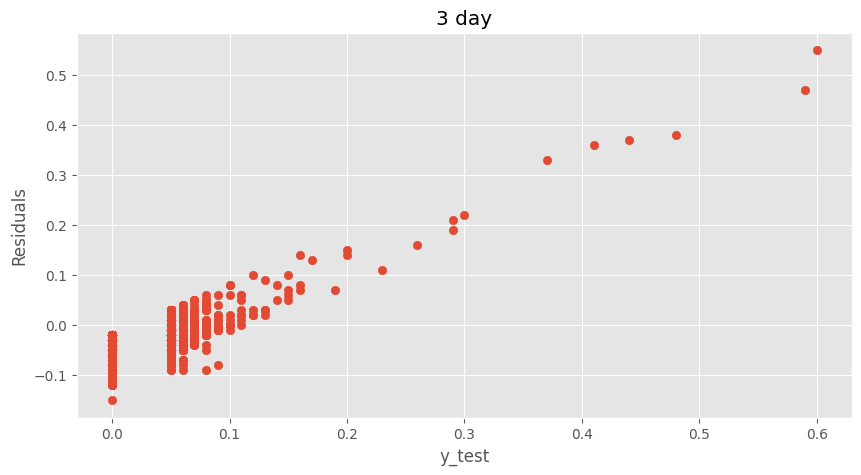

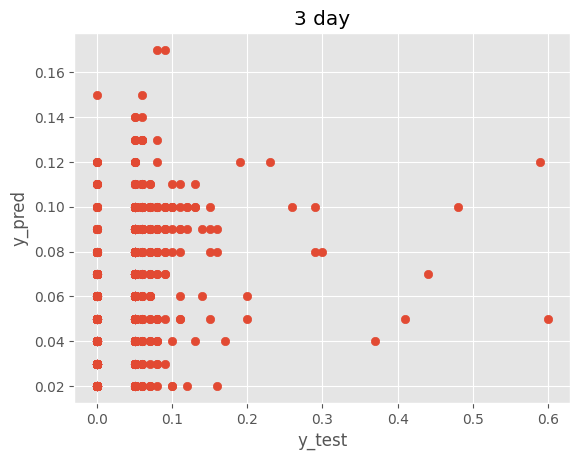

(1859, 2)


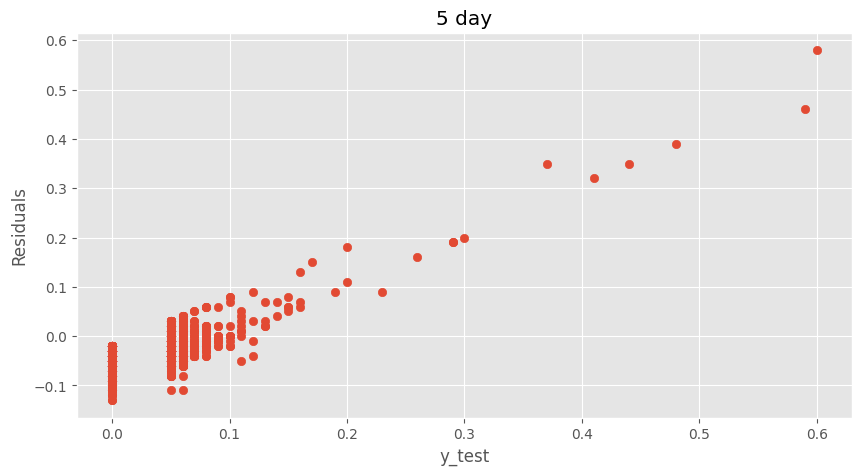

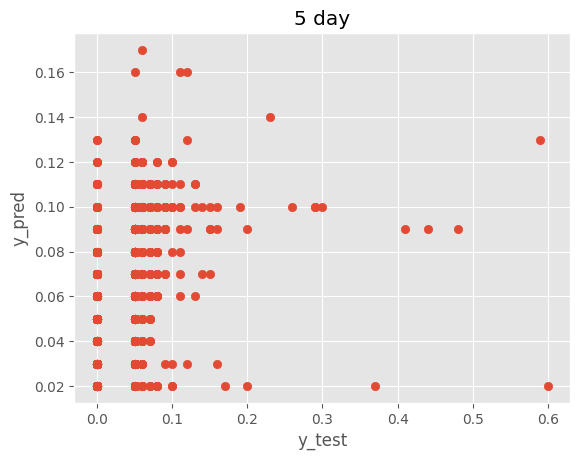

In [53]:
# 6hr(1) , 1 day(4), 3 day(12), 5 day(20)
# for 6hr resampling
count = [0,3,11,19]
model_name = ['6 hour','1 day','3 day','5 day']
# # for 3hr resampling
# count = [1,7,23,39]
# model_name = ['6 hour','1 day','3 day','5 day']
# For 12hr resampling
# count = [1,5,9]
# model_name = ['1 day','3 day','5 day']
i = 0
for f, b in zip(model_name, count):
    evaluation_steps(y_predict[b],y_test[b],f,'Bidirectional - 3Layers LSTM')
    i+=1

In [54]:
df

,Lead Time,Model Name,RMSE,MSE,MAE,R2 Score
0,6 hour,Vanialla LSTM,0.0540,0.0029,0.0310,0.2504
1,1 day,Vanialla LSTM,0.0568,0.0032,0.0324,0.1704
2,3 day,Vanialla LSTM,0.0588,0.0035,0.0344,0.1134
3,5 day,Vanialla LSTM,0.0590,0.0035,0.0349,0.1102
4,6 hour,Stacked LSTM,0.0511,0.0026,0.0307,0.1917
5,1 day,Stacked LSTM,0.0532,0.0028,0.0322,0.1247
6,3 day,Stacked LSTM,0.0543,0.0029,0.0335,0.0901
7,5 day,Stacked LSTM,0.0543,0.0030,0.0335,0.0906
8,6 hour,Stacked LSTM with Dropout LSTM,0.0471,0.0022,0.0297,0.1391
9,1 day,Stacked LSTM with Dropout LSTM,0.0492,0.0024,0.0311,0.0611
